### Imports

In [1]:
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Conv2D, LeakyReLU, UpSampling2D, InputLayer, Concatenate, Input, merge, concatenate, Lambda, Reshape, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model

import tensorflow as tf

import cv2

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Parsing the config

The network config is in `yolov3.cfg`

In [2]:
def parse_config(cfg_path, verbose=False):
    file = open(cfg_path, 'r')
    lines = file.readlines()
        
    # get rid of comments and blank lines and white space
    lines = [x for x in lines if len(x) > 1]
    lines = [x for x in lines if x[0] != '#']
    lines = [x.rstrip().lstrip() for x in lines]

    block = {}
    blocks = []
    
    for line in lines:
        if verbose: print('valuating line: %s' % line)
        
        if line[0] == '[': # new block start
            if len(block) != 0: # if the block inst empty (has data) then reset it
                blocks.append(block)
                block = {}
                
            block['type'] = line[1:-1]
        else:
            key, value = line.split('=')
            key, value = key.rstrip(), value.lstrip()
            block[key] = value

    blocks += [block]
    return blocks

In [43]:
blocks = parse_config('custom_yolo.cfg')

# configs from https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
LABELS = ['Person', 'Car', 'Bicycle', 'Bus', 'Motorbike', 'Train', 'Aeroplane', 'Chair', 'Bottle', 'Dining Table', 'Potted Plant', 'TV/Monitor', 'Sofa', 'Bird', 'Cat', 'Cow', 'Dog', 'Horse', 'Sheep']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

### Fix shortcut issue
this is a quick fix for the shortcut issue I was running into but I want to figure out why and how this works so I can create a better implementation.

In [44]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

# The model

(add specific info about the model)

### Questions:
1. Why is padding important in a convolutional layer
2. What is `BatchNormalization` and why is it important
3. What does `bilinear` mean?
4. What is `B X C X H X W` and how is it difforent than other formats
5. What is the difforence between route and shortcut and how are they implemented?
    * see the degradation problem, and an [explaination here](https://www.quora.com/What-are-shortcut-connections-how-do-they-work-and-what-is-their-role-in-the-paper-Deep-Residual-Learning-for-Image-Recognition).
6. What does `space_to_depth_x2` do?

In [45]:
input_layer = blocks[0]
input_shape = (int(input_layer['shape']), 
    int(input_layer['shape']), 
    int(input_layer['channels']))

bad_layer_that_shouldnt_be_used = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
model_input = Input(input_shape)
x = model_input

skip_connection = None
skip_connection_x = None
output = None
model = None

conv_count = 0

for index, block in enumerate(blocks[1:]):
    print('(%i/%i) processing: %s' % (index, len(blocks) - 2, block['type']))
    
    if block['type'] == 'convolutional':        
        filters = int(block['filters'])
        kernel = int(block['kernel'])
        strides = int(block['strides'])
        
        x = Conv2D(filters, 
                   (kernel, kernel), 
                   strides=(strides, strides), 
                   padding='same', 
                   name='conv_%i' % conv_count,
                   use_bias=False)(x)
        x = BatchNormalization(name='batch_norm_%i' % conv_count)(x)
        x = LeakyReLU(alpha=0.1)(x)
        
        conv_count += 1
        
    if block['type'] == 'maxpooling':
        pool = int(block['pool'])
        
        x = MaxPooling2D(pool_size=(pool, pool))(x)
        
    if block['type'] == 'skip_connection':
        open_connection = int(block['open'])
        
        if open_connection:
            skip_connection = x # hold current x for later
        else:
            skip_connection_x = x # make sure we know what this is for concat
            x = skip_connection # set x to skip connect from earlier
    
    if block['type'] == 'space_to_depth':
        x = Lambda(space_to_depth_x2)(x)
        
    if block['type'] == 'concatenate':
        x = concatenate([x, skip_connection_x])
        
    if block['type'] == 'net':
        x = Conv2D(
            BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same')(x)
        output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
        output = Lambda(lambda a: a[0])([output, bad_layer_that_shouldnt_be_used])
        
        model = Model([model_input, bad_layer_that_shouldnt_be_used], output)

(0/31) processing: convolutional
(1/31) processing: maxpooling
(2/31) processing: convolutional
(3/31) processing: maxpooling
(4/31) processing: convolutional
(5/31) processing: convolutional
(6/31) processing: convolutional
(7/31) processing: maxpooling
(8/31) processing: convolutional
(9/31) processing: convolutional
(10/31) processing: convolutional
(11/31) processing: maxpooling
(12/31) processing: convolutional
(13/31) processing: convolutional
(14/31) processing: convolutional
(15/31) processing: convolutional
(16/31) processing: convolutional
(17/31) processing: skip_connection
(18/31) processing: maxpooling
(19/31) processing: convolutional
(20/31) processing: convolutional
(21/31) processing: convolutional
(22/31) processing: convolutional
(23/31) processing: convolutional
(24/31) processing: convolutional
(25/31) processing: convolutional
(26/31) processing: skip_connection
(27/31) processing: convolutional
(28/31) processing: space_to_depth
(29/31) processing: concatenate
(3

In [46]:
model.summary()
plot_model(model, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_norm_0 (BatchNormalizatio (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)      (None, 416, 416, 32) 0           batch_norm_0[0][0]               
__________________________________________________________________________________________________
max_poolin

## Predictions
Output and generating predictions

### Output Tensor
![image](https://cdn-images-1.medium.com/max/1600/1*cGfWw6lGmV1xUKRsd--JxQ.png)

Each coordinate is represented like this:
![image.png](https://blog.paperspace.com/content/images/2018/04/bbox_-2.png)
the coordinates are the x, y in the matrix of anchors

In [47]:
import cv2

img = cv2.imread("dog-cycle-car.png")
img = cv2.resize(img, (416, 416)) # resize to the input dimension
img_ =  img[:, :, ::-1].transpose((2, 0, 1))  # BGR -> RGB | H X W C -> C X H X W 
img.shape

(416, 416, 3)

In [48]:
test_prediction = model.predict(np.array([img]))
test_prediction.shape

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[ 57,  61,  61],
         [ 57,  61,  61],
         [ 57,  61,  61],
         ...,
         [154, 237, 215],
         [ 84, 144, 137],
         [ 28,  68,  67]],

        [[ 57,  61,  61],
 ...

The above output will need to be changed into a an array like the one in the image above

### Questions
1. what is the 3rd attribute
2. could you use another network to decrease grid size?
3. what is this doing? `tf.math.exp(prediction[:, :, 2:4]) * anchors`

In [49]:
def format_prediction(prediction, network_info):
    """
    :param network_info: first block
    """
#     from IPython.core.debugger import Tracer; Tracer()()
    
    anchors = [(10,13),  (16,30),  (33,23),  (30,61),  (62,45),  (59,119),  (116,90),  (156,198),  (373,326)]
    
    network_height = int(network_info['height'])
    network_class_count = int(network_info['classes'])
    
    shape = prediction.shape
    batch_size = shape[0]
    stride = network_height // shape[2] # strides to map output position to real position
    grid_size = network_height // stride
    box_attributes = 5 + network_class_count # each box starts out with 5 attributes (xmin, xmax, ymin, ymax, ?)
    anchor_count = len(anchors) # TODO: get anchors from yolo layer
    
    prediction = prediction.reshape((
        batch_size, box_attributes * anchor_count, grid_size * grid_size))
    prediction = tf.transpose(tf.reshape(prediction, [1, 2]))
    prediction = prediction.reshape((
        batch_size, grid_size * grid_size * num_anchors, box_attributes))
    
    anchors = [(a[0] / stride, a[1] / stride) for a in anchors] # update anchors for strides
    prediction[:, :, 0] = tf.math.sigmoid(prediction[:, :, 0]) # apply sigmoid to x, y and confidence
    prediction[:, :, 1] = tf.math.sigmoid(prediction[:, :, 1])
    prediction[:, :, 4] = tf.math.sigmoid(prediction[:, :, 4])
    
    grid = np.arange(grid_size)
    a, b = np.meshgrid(grid, grid)
    
    x_offset = a.reshape((-1, 1))
    y_offset = b.reshape((-1, 1))
    
    x_y_offset = np.concatenate((x_offset, y_offset), axis=1).repeat(1, num_anchors).reshape((1, -1, 2))
    
    prediction[:, :, :2] += x_y_offset

    anchors = anchors.repeat(grid_size * grid_size, 1)
    anchors = anchors.reshape((1,) + anchors.shape)
    
    prediction[:, :, 2:4] = tf.math.exp(prediction[:, :, 2:4]) * anchors
    # apply sigmoid activation to all the classes
    prediction[:, :, 5:5 + num_classes] = tf.math.sigmoid((prediction[:, :, 5:5 + num_classes]))

    prediction[:, :, :4] *= stride # to make it reasonable for boxes
    return prediction

In [50]:
img = cv2.imread("dog-cycle-car.png")
img = cv2.resize(img, (416, 416)) # resize to the input dimension
img_ =  img[:, :, ::-1].transpose((2, 0, 1))  # BGR -> RGB | H X W C -> C X H X W 

blocks[0]['classes'] = 80 # TODO load from yolo layer

test_prediction = main_modle.predict(np.array([img]))
test_prediction = format_prediction(test_prediction, blocks[0])

NameError: name 'main_modle' is not defined

# Loading Weights

We want to create a class that will allow us to load the weights and read chucks of values.

## Questions
1. How are weights stored?
2. beta, gamma, mean, var?
3. why is there no bias needed if there are already weights
    * I think that maybe what the below if statement does is not check for weights but check for `use_bias` which would explain both things
4. does this to check for previos weights or something else? `len(conv_layer.get_weights()) > 1`
5. why are the last layer's weights randomized? 
    * I _think_ this is so that some small training will be able to get a good result

In [51]:
class WeightReader:
    def __init__(self, file):
        self.offset = 4 # starting offset
        self.weights = np.fromfile(file, dtype='float32') # load a file using numpy
        
    def read(self, size):
        self.offset += size # increase offset
        return self.weights[self.offset - size: self.offset] # read from values
    
    def reset(self):
        self.offset = 4

In [63]:
"""
Much of the below code block was not written by me. See link to orininal below:
https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
"""

weight_reader = WeightReader('yolov2-voc.weights')

# thanks to @experiencor for help with this
# this will take a while (~2 mins)
for index in range(conv_count):
    conv_layer = model.get_layer('conv_%i' % index)
    norm_layer = model.get_layer('batch_norm_%i' % index)
    
    size = np.prod(norm_layer.get_weights()[0].shape) # get product of shape (total values)

    # read sizes
    beta  = weight_reader.read(size)    
    gamma = weight_reader.read(size)
    mean  = weight_reader.read(size)
    var   = weight_reader.read(size)
    
    norm_layer.set_weights([gamma, beta, mean, var])
    
    if len(conv_layer.get_weights()) > 1: # ~~we already have some weights here~~ I think this actually checks for the `use_bias` flag
        bias   = weight_reader.read(np.prod(conv_layer.get_weights()[1].shape)) # get enough weights to fill the current weight shape
        kernel = weight_reader.read(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape))) # reshape
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read(np.prod(conv_layer.get_weights()[0].shape)) # same as above without bias
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel])

In [53]:
# TODO: try running this and try without running this

layer = model.get_layer('conv_%i' % (conv_count - 1))
weights = layer.get_weights()
print(len(weights))

random_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
random_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

layer.set_weights([random_kernel, random_bias])

1


IndexError: list index out of range

In [54]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)


def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    


def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 2)
        
    return image   

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


[]

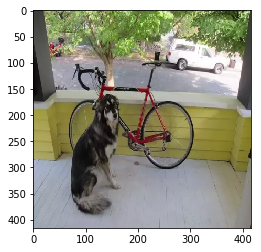

In [59]:
img = cv2.imread("dog-cycle-car.png")
img = cv2.resize(img, (416, 416)) # resize to the input dimension
img = img / 255
img = img[..., ::-1] # .transpose((2, 0, 1))  # BGR -> RGB | H X W C -> C X H X W 
img_input = np.array([img])

dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))

test_prediction = model.predict([img_input, dumby_array])
boxes = decode_netout(test_prediction[0],
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
img = draw_boxes(img, boxes, labels=LABELS)
img.shape
plt.imshow(img)
boxes